In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import keras
import os
from keras import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from io import BytesIO
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
input_shape = (128, 128, 3)

In [3]:
# # Initial Model, Sigmoid Activation
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(64, (5, 5), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(100, activation='sigmoid'))
# model.add(Dense(2, activation='softmax'))

In [4]:
# # Second Model, ReLu Activation (Taking TOO LONG)
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(64, (4, 4), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(100, activation='sigmoid'))
# model.add(Dense(2, activation='softmax'))

In [5]:
# # Third Model, ReLu Activation Saw no increase in accuracy
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(4, 4), strides=(1, 1), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(1000, activation='relu'))
# model.add(Dense(500, activation='relu'))
# model.add(Dense(250, activation='relu'))
# model.add(Dense(2, activation='softmax'))

In [6]:
#Fourth model, Relu activation, addition of batch normalization saw an improvement in accuracy
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape = (128, 128, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units = 4000, activation = 'relu'))
model.add(Dense(units = 2000, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 1000, activation = 'relu'))
model.add(Dense(units = 500, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 250, activation = 'relu'))
model.add(Dense(units = 2, activation = 'softmax'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 63, 63, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        65600     
__________

In [10]:
# Compiling the CNN
from keras import optimizers

opt = optimizers.Adam(lr=0.01)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc = []
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))

history_cb = LossHistory()

In [13]:
start_time = time.time()

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255, validation_split=0.2)


#lower batch size improved performance, lowering time to complete epoch
batch_sz=16

training_set = train_datagen.flow_from_directory('dataset/all_cards', target_size = (128, 128), batch_size = batch_sz, 
                                                 class_mode = 'categorical',classes=['legal','illegal'], 
                                                 subset='training')
#                                                  , save_to_dir='preview2', save_prefix='mtg_card', save_format='jpeg')

test_set = train_datagen.flow_from_directory('dataset/all_cards', target_size = (128, 128), batch_size = batch_sz, 
                                                 class_mode = 'categorical',classes=['legal','illegal'], 
                                                 subset='validation')


model.fit_generator(training_set, steps_per_epoch=1100, epochs = 20, validation_steps=400, validation_data = test_set, callbacks=[history_cb],workers=3)
elapsed_time = time.time() - start_time
print(elapsed_time)

Found 2807 images belonging to 2 classes.
Found 701 images belonging to 2 classes.
Epoch 1/20
1100/1100 [==============================] - 123s 112ms/step - loss: 0.4729 - acc: 0.8465 - val_loss: 0.3255 - val_acc: 0.8917
Epoch 2/20
1100/1100 [==============================] - 118s 107ms/step - loss: 0.1967 - acc: 0.9310 - val_loss: 0.4880 - val_acc: 0.7405
Epoch 3/20
1100/1100 [==============================] - 119s 108ms/step - loss: 0.1799 - acc: 0.9331 - val_loss: 0.2453 - val_acc: 0.9074
Epoch 4/20
1100/1100 [==============================] - 118s 108ms/step - loss: 0.1351 - acc: 0.9563 - val_loss: 0.1361 - val_acc: 0.9520
Epoch 5/20
1100/1100 [==============================] - 118s 108ms/step - loss: 0.1391 - acc: 0.9511 - val_loss: 0.4765 - val_acc: 0.7995
Epoch 6/20
1100/1100 [==============================] - 118s 107ms/step - loss: 0.1348 - acc: 0.9523 - val_loss: 2.5345 - val_acc: 0.6109
Epoch 7/20
1100/1100 [==============================] - 147s 134ms/step - loss: 0.1378 - 

In [1]:
modelname='mtg-ml-cnn-relu-20ep-3c-5hd.h5'
model.save(modelname)

NameError: name 'model' is not defined

In [15]:
# model=keras.models.load_model('model_one.h5')

Text(0, 0.5, 'Accuracy')

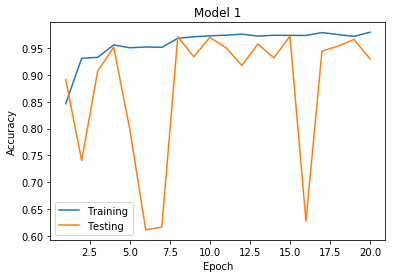

In [16]:
modelHistory = history_cb
xVal = np.arange(1, 1+20, 1)
plt.plot(xVal, modelHistory.acc)
plt.plot(xVal, modelHistory.val_acc)
plt.title('Model 1')
plt.legend(("Training", "Testing"), loc="best")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [17]:
predict_datagen=ImageDataGenerator(rescale=1./255)
predict_set=predict_datagen.flow_from_directory('prediction', target_size = (128, 128), 
                                                 class_mode = None)

y_hat=model.predict_generator(predict_set,steps=1, verbose=0)
for i in y_hat:
    print(i)
    if i[0]>.5:
        print("Card is Standard Legal\n")
    else:
        print("Card is Not in Standard\n")
    

Found 1 images belonging to 1 classes.
[9.9986768e-01 1.3227777e-04]
Card is Standard Legal



In [18]:
# K.clear_session()
# del model
# import gc
# gc.collect()